# Acoustic Navigation Training Notebook

In [1]:
import torch
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)        # None => CPU-only build
print("cuda available:", torch.cuda.is_available())  # should be True
print("cuda built:", torch.backends.cuda.is_built()) # True if GPU build


torch: 2.9.1+cu126
built with CUDA: 12.6
cuda available: True
cuda built: True


In [ ]:
import sys
sys.path.append('../')

import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from src.cave_dataset import (
    MultiCaveDataset,
    ACTION_MAP,
    ACTION_NAMES,
    MIC_OFFSETS,
    compute_class_distribution,
    compute_class_weights,
)
from src.models import CompactAcousticNet, SpatialTemporalAcousticNet, FocalLoss
from src.lmdb_dataset import LMDBAcousticDataset

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
np.random.seed(42)
torch.manual_seed(42)

2.9.1+cu126
Using device: cuda


In [ ]:
# Cell 4+5: Perfectly Balanced Dataset Setup
# ---------------------------------------------------------
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
from collections import defaultdict
from src.lmdb_dataset import LMDBAcousticDataset 

# 1. Load Raw Data
# UPDATE PATH IF NEEDED
DATASET_DIR = Path('D:/audiomaze_dataset_100')
raw_dataset = LMDBAcousticDataset('D:/audiomaze_lmdb_100')

# 2. Scan and Sort Indices by Class
print("Scanning dataset to group indices by class...")
indices_by_class = defaultdict(list)

# Iterate through dataset to sort indices
for idx in range(len(raw_dataset)):
    _, action, _, _ = raw_dataset[idx]
    act = int(action)
    # We only care about 1=UP, 2=DOWN, 3=LEFT, 4=RIGHT (Filter out STOP=0)
    if act in [1, 2, 3, 4]:
        indices_by_class[act].append(idx)

# 3. Dynamic Downsampling (Match the smallest class)
min_count = min(len(indices_by_class[c]) for c in [1, 2, 3, 4])
print(f"\nClass Counts Found: { {k: len(v) for k,v in indices_by_class.items()} }")
print(f"--> Downsampling all classes to match the smallest: {min_count} samples each")

# 4. Create Perfectly Balanced Index List
balanced_indices = []
for cls in [1, 2, 3, 4]:
    balanced_indices.extend(random.sample(indices_by_class[cls], min_count))

# Shuffle to mix classes
random.shuffle(balanced_indices)

# 5. Create Dataset & Split
balanced_dataset = Subset(raw_dataset, balanced_indices)
balanced_targets = [raw_dataset[i][1].item() for i in balanced_indices]

train_idx, val_idx = train_test_split(
    np.arange(len(balanced_dataset)), 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_targets
)

train_dataset = Subset(balanced_dataset, train_idx)
val_dataset = Subset(balanced_dataset, val_idx)

# 6. Loaders
BATCH_SIZE = 128 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✅ Data Ready:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")

c:\Users\danyi\repo\Audio-Maze-Navigation\.venv\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


Loaded LMDB dataset: 96,868 samples
Action distribution: {'stop': 100, 'up': 48697, 'down': 43300, 'left': 2318, 'right': 2453}
Scanning dataset to group indices by class...

Class Counts Found: {2: 43300, 4: 2453, 3: 2318, 1: 48697}
--> Downsampling all classes to match the smallest: 2318 samples each

✅ Data Ready:
  Train: 7417 samples
  Val:   1855 samples


In [ ]:
# Cell 6: Model Initialization (WideFieldNet)
# ---------------------------------------------------------
import torch.nn as nn
import torch
from src.models import WideFieldNet

# Instantiate from module
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WideFieldNet(num_classes=4, dropout=0.5).to(device)

# Using standard AdamW as established in experiments
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

print("✅ WideFieldNet Loaded from src.models")
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

Using SpatialTemporalAcousticNet
Total parameters: 1,268,901
Using FocalLoss (gamma=2.0) to handle class hardness


In [ ]:
# Cell 7: Final Training Loop
# ---------------------------------------------------------
from tqdm.auto import tqdm
import torch
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report
from contextlib import nullcontext

# Config
EPOCHS = 20
save_dir = Path("checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)

# AMP Setup
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else torch.amp.GradScaler(enabled=False)
autocast_ctx = lambda: torch.amp.autocast('cuda') if torch.cuda.is_available() else nullcontext()

best_val_acc = 0.0

print("=" * 60)
print(f"STARTING TRAINING")
print("=" * 60)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", dynamic_ncols=True, colour="#4CAF50")
    for mic, action, _, _ in pbar:
        mic = mic.to(device, non_blocking=True)
        action = action.to(device, non_blocking=True)
        targets = action - 1 # Map 1-4 -> 0-3
        
        optimizer.zero_grad(set_to_none=True)
        with autocast_ctx():
            logits = model(mic)
            loss = criterion(logits, targets)
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * mic.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == targets).sum().item()
        train_total += targets.numel()
        
        pbar.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # --- VALIDATION ---
    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for mic, action, _, _ in val_loader:
            mic = mic.to(device, non_blocking=True)
            action = action.to(device, non_blocking=True)
            targets = action - 1

            with autocast_ctx():
                logits = model(mic)
            
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.numel()
            
            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    avg_val_acc = val_correct / val_total
    scheduler.step(avg_val_acc)
    
    print(f"\nSummary Ep {epoch+1}: Val Acc {avg_val_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save Best Model
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), save_dir / "best_model_widefield.pt")
        print("  --> Saved Best Model")
        
    print(classification_report(all_targets, all_preds, target_names=['UP', 'DOWN', 'LEFT', 'RIGHT'], zero_division=0))
    print("-" * 60)

STARTING FINAL TRAINING RUN


Ep 1/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 1: Val Acc 0.250 | LR: 1.00e-04
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.25      1.00      0.40       464
        DOWN       0.00      0.00      0.00       463
        LEFT       0.00      0.00      0.00       464
       RIGHT       0.00      0.00      0.00       464

    accuracy                           0.25      1855
   macro avg       0.06      0.25      0.10      1855
weighted avg       0.06      0.25      0.10      1855

------------------------------------------------------------


Ep 2/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 2: Val Acc 0.280 | LR: 1.00e-04
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.00      0.00      0.00       464
        DOWN       0.27      0.96      0.42       463
        LEFT       0.00      0.00      0.00       464
       RIGHT       0.41      0.16      0.23       464

    accuracy                           0.28      1855
   macro avg       0.17      0.28      0.16      1855
weighted avg       0.17      0.28      0.16      1855

------------------------------------------------------------


Ep 3/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 3: Val Acc 0.328 | LR: 1.00e-04
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.37      0.20      0.26       464
        DOWN       0.00      0.00      0.00       463
        LEFT       0.40      0.35      0.38       464
       RIGHT       0.29      0.76      0.42       464

    accuracy                           0.33      1855
   macro avg       0.27      0.33      0.27      1855
weighted avg       0.27      0.33      0.27      1855

------------------------------------------------------------


Ep 4/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 4: Val Acc 0.282 | LR: 1.00e-04
              precision    recall  f1-score   support

          UP       0.00      0.00      0.00       464
        DOWN       0.27      0.94      0.42       463
        LEFT       0.35      0.02      0.04       464
       RIGHT       0.40      0.17      0.24       464

    accuracy                           0.28      1855
   macro avg       0.25      0.28      0.17      1855
weighted avg       0.25      0.28      0.17      1855

------------------------------------------------------------


Ep 5/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 5: Val Acc 0.328 | LR: 1.00e-04
              precision    recall  f1-score   support

          UP       0.49      0.04      0.08       464
        DOWN       0.32      0.40      0.35       463
        LEFT       0.39      0.21      0.27       464
       RIGHT       0.31      0.66      0.42       464

    accuracy                           0.33      1855
   macro avg       0.38      0.33      0.28      1855
weighted avg       0.38      0.33      0.28      1855

------------------------------------------------------------


Ep 6/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 6: Val Acc 0.284 | LR: 1.00e-04
              precision    recall  f1-score   support

          UP       0.00      0.00      0.00       464
        DOWN       0.27      0.97      0.42       463
        LEFT       0.45      0.07      0.13       464
       RIGHT       0.46      0.09      0.16       464

    accuracy                           0.28      1855
   macro avg       0.29      0.28      0.18      1855
weighted avg       0.29      0.28      0.18      1855

------------------------------------------------------------


Ep 7/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 7: Val Acc 0.313 | LR: 5.00e-05
              precision    recall  f1-score   support

          UP       0.29      0.86      0.43       464
        DOWN       0.33      0.00      0.00       463
        LEFT       0.71      0.01      0.02       464
       RIGHT       0.39      0.38      0.39       464

    accuracy                           0.31      1855
   macro avg       0.43      0.31      0.21      1855
weighted avg       0.43      0.31      0.21      1855

------------------------------------------------------------


Ep 8/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 8: Val Acc 0.291 | LR: 5.00e-05
              precision    recall  f1-score   support

          UP       1.00      0.01      0.01       464
        DOWN       0.27      0.89      0.42       463
        LEFT       0.75      0.01      0.01       464
       RIGHT       0.37      0.26      0.30       464

    accuracy                           0.29      1855
   macro avg       0.60      0.29      0.19      1855
weighted avg       0.60      0.29      0.19      1855

------------------------------------------------------------


Ep 9/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 9: Val Acc 0.355 | LR: 5.00e-05
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.39      0.31      0.35       464
        DOWN       0.43      0.12      0.18       463
        LEFT       0.45      0.26      0.33       464
       RIGHT       0.31      0.72      0.43       464

    accuracy                           0.35      1855
   macro avg       0.40      0.35      0.32      1855
weighted avg       0.40      0.35      0.32      1855

------------------------------------------------------------


Ep 10/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 10: Val Acc 0.371 | LR: 5.00e-05
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.43      0.31      0.36       464
        DOWN       0.32      0.55      0.41       463
        LEFT       0.41      0.22      0.29       464
       RIGHT       0.39      0.41      0.40       464

    accuracy                           0.37      1855
   macro avg       0.39      0.37      0.36      1855
weighted avg       0.39      0.37      0.36      1855

------------------------------------------------------------


Ep 11/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 11: Val Acc 0.315 | LR: 5.00e-05
              precision    recall  f1-score   support

          UP       0.37      0.29      0.32       464
        DOWN       0.35      0.18      0.24       463
        LEFT       0.29      0.78      0.43       464
       RIGHT       0.50      0.00      0.00       464

    accuracy                           0.31      1855
   macro avg       0.38      0.31      0.25      1855
weighted avg       0.38      0.31      0.25      1855

------------------------------------------------------------


Ep 12/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 12: Val Acc 0.370 | LR: 5.00e-05
              precision    recall  f1-score   support

          UP       0.35      0.63      0.45       464
        DOWN       0.34      0.35      0.35       463
        LEFT       0.42      0.22      0.29       464
       RIGHT       0.41      0.27      0.33       464

    accuracy                           0.37      1855
   macro avg       0.38      0.37      0.36      1855
weighted avg       0.38      0.37      0.36      1855

------------------------------------------------------------


Ep 13/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 13: Val Acc 0.349 | LR: 5.00e-05
              precision    recall  f1-score   support

          UP       0.47      0.17      0.25       464
        DOWN       0.30      0.73      0.43       463
        LEFT       0.38      0.23      0.29       464
       RIGHT       0.43      0.26      0.32       464

    accuracy                           0.35      1855
   macro avg       0.40      0.35      0.32      1855
weighted avg       0.40      0.35      0.32      1855

------------------------------------------------------------


Ep 14/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 14: Val Acc 0.333 | LR: 2.50e-05
              precision    recall  f1-score   support

          UP       0.32      0.69      0.43       464
        DOWN       0.45      0.02      0.04       463
        LEFT       0.50      0.05      0.09       464
       RIGHT       0.34      0.58      0.43       464

    accuracy                           0.33      1855
   macro avg       0.40      0.33      0.25      1855
weighted avg       0.40      0.33      0.25      1855

------------------------------------------------------------


Ep 15/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 15: Val Acc 0.384 | LR: 2.50e-05
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.34      0.67      0.45       464
        DOWN       0.46      0.17      0.25       463
        LEFT       0.42      0.37      0.39       464
       RIGHT       0.43      0.33      0.37       464

    accuracy                           0.38      1855
   macro avg       0.41      0.38      0.37      1855
weighted avg       0.41      0.38      0.37      1855

------------------------------------------------------------


Ep 16/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 16: Val Acc 0.373 | LR: 2.50e-05
              precision    recall  f1-score   support

          UP       0.39      0.33      0.36       464
        DOWN       0.36      0.09      0.15       463
        LEFT       0.35      0.63      0.45       464
       RIGHT       0.41      0.44      0.42       464

    accuracy                           0.37      1855
   macro avg       0.38      0.37      0.34      1855
weighted avg       0.38      0.37      0.34      1855

------------------------------------------------------------


Ep 17/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 17: Val Acc 0.357 | LR: 2.50e-05
              precision    recall  f1-score   support

          UP       0.42      0.29      0.35       464
        DOWN       0.31      0.70      0.43       463
        LEFT       0.38      0.25      0.30       464
       RIGHT       0.48      0.19      0.27       464

    accuracy                           0.36      1855
   macro avg       0.40      0.36      0.34      1855
weighted avg       0.40      0.36      0.34      1855

------------------------------------------------------------


Ep 18/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 18: Val Acc 0.395 | LR: 2.50e-05
  --> Saved Best Model to checkpoints\best_model_widefield.pt
              precision    recall  f1-score   support

          UP       0.40      0.41      0.41       464
        DOWN       0.37      0.29      0.33       463
        LEFT       0.39      0.42      0.41       464
       RIGHT       0.41      0.45      0.43       464

    accuracy                           0.39      1855
   macro avg       0.39      0.39      0.39      1855
weighted avg       0.39      0.39      0.39      1855

------------------------------------------------------------


Ep 19/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 19: Val Acc 0.336 | LR: 2.50e-05
              precision    recall  f1-score   support

          UP       0.30      0.80      0.43       464
        DOWN       0.43      0.05      0.09       463
        LEFT       0.39      0.31      0.34       464
       RIGHT       0.45      0.19      0.27       464

    accuracy                           0.34      1855
   macro avg       0.39      0.34      0.28      1855
weighted avg       0.39      0.34      0.28      1855

------------------------------------------------------------


Ep 20/20:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 20: Val Acc 0.374 | LR: 2.50e-05
              precision    recall  f1-score   support

          UP       0.41      0.27      0.32       464
        DOWN       0.37      0.13      0.19       463
        LEFT       0.34      0.65      0.45       464
       RIGHT       0.41      0.45      0.43       464

    accuracy                           0.37      1855
   macro avg       0.38      0.37      0.35      1855
weighted avg       0.38      0.37      0.35      1855

------------------------------------------------------------


Loading best model from checkpoints\best_model_widefield.pt...


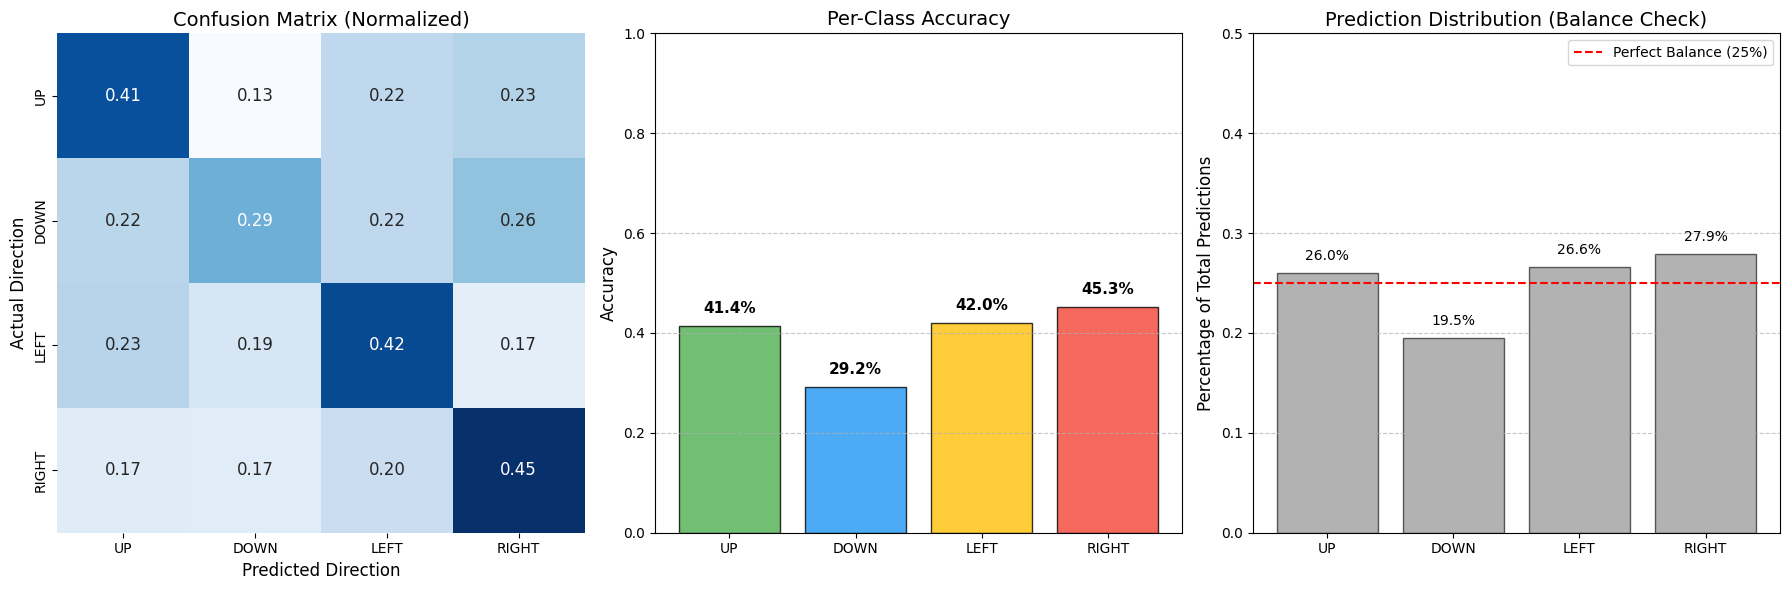


--- FULL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

          UP       0.40      0.41      0.41       464
        DOWN       0.37      0.29      0.33       463
        LEFT       0.39      0.42      0.41       464
       RIGHT       0.41      0.45      0.43       464

    accuracy                           0.39      1855
   macro avg       0.39      0.39      0.39      1855
weighted avg       0.39      0.39      0.39      1855

Plots saved to 'final_validation_results.png'


In [10]:
# Cell 8: Final Validation & Visualization Output
# ---------------------------------------------------------
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from pathlib import Path # Ensure Path is imported

# --- CRITICAL FIX: Load the Best Model ---
# This ensures we evaluate the peak performance, not just the last epoch
save_dir = Path("checkpoints")
best_model_path = save_dir / "best_model_widefield.pt"

if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path))
else:
    print("⚠️ Warning: Best model not found. Using current (latest) model.")

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for mic, action, _, _ in val_loader:
        mic = mic.to(device, non_blocking=True)
        # Remap action 1-4 to target 0-3
        targets = (action - 1).to(device)
        
        with autocast_ctx():
            logits = model(mic)
        
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

class_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

# --- PLOTTING ---
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)

# Plot 1: Normalized Confusion Matrix
# ---------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize by row

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, ax=ax1, annot_kws={"size": 12})
ax1.set_title('Confusion Matrix (Normalized)', fontsize=14)
ax1.set_ylabel('Actual Direction', fontsize=12)
ax1.set_xlabel('Predicted Direction', fontsize=12)

# Plot 2: Per-Class Accuracy (Diagonal of CM)
# ---------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
class_acc = cm.diagonal() / cm.sum(axis=1)
colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336'] # Green, Blue, Amber, Red

bars = ax2.bar(class_names, class_acc, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylim(0, 1.0)
ax2.set_title('Per-Class Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: Prediction Distribution (Are we balanced?)
# ---------------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2])
pred_counts = Counter(all_preds)
total_preds = sum(pred_counts.values())
pred_pcts = [pred_counts.get(i, 0) / total_preds for i in range(4)]

bars3 = ax3.bar(class_names, pred_pcts, color='gray', alpha=0.6, edgecolor='black')
ax3.set_ylim(0, 0.5) # Scale to 50%
ax3.set_title('Prediction Distribution (Balance Check)', fontsize=14)
ax3.set_ylabel('Percentage of Total Predictions', fontsize=12)
ax3.axhline(y=0.25, color='r', linestyle='--', label='Perfect Balance (25%)')
ax3.legend()
ax3.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('final_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n--- FULL CLASSIFICATION REPORT ---")
print(classification_report(all_targets, all_preds, target_names=class_names, zero_division=0))
print(f"Plots saved to 'final_validation_results.png'")